In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [2]:
import scipy.sparse as sparse
import scipy.sparse.linalg as sl

n = 20
e = np.ones((n,))
A = sparse.spdiags([-e,2*e,-e], [-1,0,1], n, n)

In [3]:
print(A.todense()[:5,:5])

[[ 2. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  2.]]


### Implement the three different stationary iterative methods.


We implement the following methods
1. Jacobi 
2. Gauss-Seidel
3. SOR methods

In [4]:
def jacobi(A, b, xtrue, maxiter = 100):
    L = sparse.tril(A, k = -1)
    U = sparse.triu(A, k = 1)
    D = sparse.diags(A.diagonal(), 0, format = "csc")
    
    A2 = (L+U)
    A1 = D
    
    xkm1 = 0*b
    
    err = np.zeros((maxiter,), dtype = 'd')
    
    for k in range(maxiter): 
        
        xk = sl.spsolve(A1, -A2 @ xkm1 + b)
        
        #Compute relative error if the solution is available
        err[k] = np.linalg.norm(xk -xtrue)/np.linalg.norm(xtrue)
    
        xkm1 = np.copy(xk)
    
    return err
    
    
def gaussseidel(A, b, xtrue, maxiter = 100):
    
    L = sparse.tril(A, k = -1)
    U = sparse.triu(A, k = 1)
    D = sparse.diags(A.diagonal(), 0, format = "csc")
    
    A2 = U
    A1 = L+D
    
    xkm1 = 0*b
    
    err = np.zeros((maxiter,), dtype = 'd')
    
    for k in range(maxiter): 
        
        xk = sl.spsolve(A1, -A2 @ xkm1 + b)
        
        #Compute relative error if the solution is available
        err[k] = np.linalg.norm(xk -xtrue)/np.linalg.norm(xtrue)
    
        xkm1 = np.copy(xk)
    
    return err

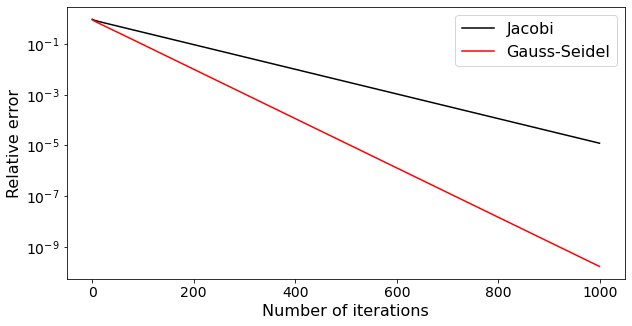

In [5]:
xtrue = np.ones((n,))
b = A @ xtrue

errj = jacobi(A, b, xtrue, maxiter = 1000)
errgs = gaussseidel(A, b, xtrue, maxiter = 1000)
plt.semilogy(range(1000), errj, 'k-', range(1000), errgs, 'r-')
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Relative error', fontsize = 16)
plt.legend(('Jacobi', 'Gauss-Seidel'), fontsize = 16)

### Successive over-relaxation method

In [6]:
def sor(A, b, xtrue, omega = 1., maxiter = 100):
    
    L = sparse.tril(A, k = -1)
    U = sparse.triu(A, k = 1)
    D = sparse.diags(A.diagonal(), 0, format = "csc")
    
    A2 = (1-1/omega)*D + U
    A1 = L+D/omega
    
    xkm1 = 0*b
    
    err = np.zeros((maxiter,), dtype = 'd')
    
    for k in range(maxiter): 
        
        xk = sl.spsolve_triangular(A1, -A2 @ xkm1 + b)
        
        #Compute relative error if the solution is available
        err[k] = np.linalg.norm(xk -xtrue)/np.linalg.norm(xtrue)
    
        xkm1 = np.copy(xk)
    
    return err

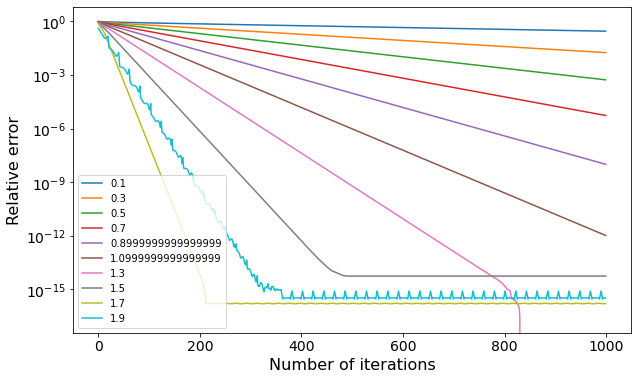

In [7]:
xtrue = np.ones((n,))
b = A @ xtrue

no = 10
omegalst = np.linspace(0.1,1.9,no)
f = plt.figure(figsize = (10,6))
for k in range(no):
    errsor = sor(A, b, xtrue, omega = omegalst[k], maxiter = 1000)
    plt.semilogy(range(1000), errsor, '-')
    

plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Relative error', fontsize = 16)
plt.legend( tuple([str(omegalst[k]) for k in range(no)]))

### SOR on a large matrix

This is a matrix that arises from the discretization of a 2D elliptic PDE. The second matrix $A$ has 5 nonzero diagonals and arises from 2D Poisson's equation,
$$ -\Delta u = f ,$$

with Dirichlet boundary conditions. This gives the following sparse matrix:


$$ A = T \otimes I + I \otimes T ,$$

where $T$ is a tridiagonal matrix and $\otimes$ is the Kronecker product. 


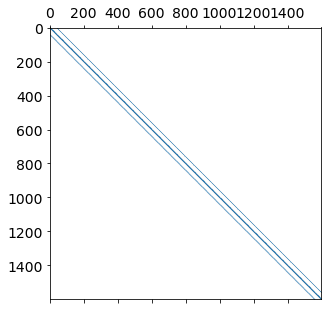

In [8]:
n = 40
e = np.ones((n,))
A = sparse.spdiags([-e,2*e,-e], [-1,0,1], n, n)
A = sparse.kronsum(A, A)

plt.spy(A, markersize = 0.05)

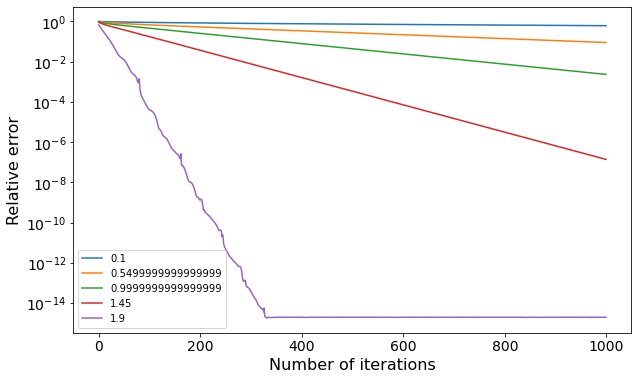

In [9]:
xtrue = np.ones((A.shape[0],))
b = A @ xtrue

no = 5
omegalst = np.linspace(0.1,1.9,no)
f = plt.figure(figsize = (10,6))
for k in range(no):
    errsor = sor(A, b, xtrue, omega = omegalst[k], maxiter = 1000)
    plt.semilogy(range(1000), errsor, '-')
    

plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Relative error', fontsize = 16)
plt.legend( tuple([str(omegalst[k]) for k in range(no)]))


### Real-world matrix

In [10]:
from scipy.io import mmread, loadmat
from scipy.sparse.linalg import splu
from scipy.sparse import csc_matrix

A = mmread('airfoil_2d.mtx')
A = csc_matrix(A)

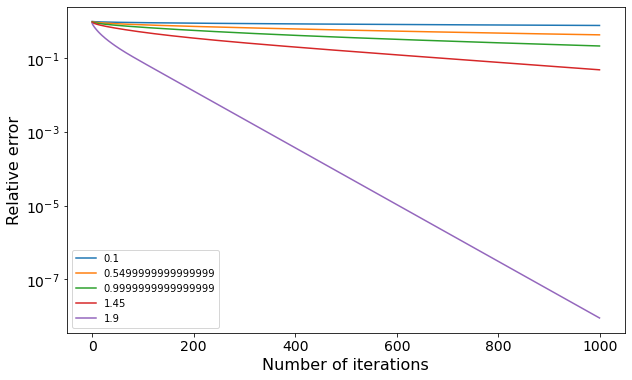

In [11]:
xtrue = np.ones((A.shape[0],))
b = A @ xtrue

no = 5
omegalst = np.linspace(0.1,1.9,no)
f = plt.figure(figsize = (10,6))
for k in range(no):
    errsor = sor(A, b, xtrue, omega = omegalst[k], maxiter = 1000)
    plt.semilogy(range(1000), errsor, '-')
    

plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Relative error', fontsize = 16)
plt.legend( tuple([str(omegalst[k]) for k in range(no)]))
